Fake Tweets about COVID 19 Vaccine Detection using Transformers

In [206]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model
import numpy as np
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import tensorflow
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow. keras .preprocessing.sequence import pad_sequences
from tensorflow. keras.models import Sequential
from tensorflow. keras. layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

Building Transformer

In [207]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"),
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [208]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Loading Dataset

In [209]:
reliable=pd.read_csv('/content/drive/MyDrive/relaible.csv')

reliable['ns_label'].value_counts()
#reliable.columns

<ipython-input-209-c905bc801622>:1: DtypeWarning: Columns (7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  reliable=pd.read_csv('/content/drive/MyDrive/relaible.csv')


reliable    217279
Name: ns_label, dtype: int64

In [210]:
unreliable=pd.read_csv('/content/drive/MyDrive/unrelaible.csv')

unreliable['ns_label'].value_counts()
#unreliable.columns

<ipython-input-210-6b20aee5d955>:1: DtypeWarning: Columns (7,8,9,10,11,12,13,14,58) have mixed types. Specify dtype option on import or set low_memory=False.
  unreliable=pd.read_csv('/content/drive/MyDrive/unrelaible.csv')


unreliable    26639
Name: ns_label, dtype: int64

Removing Empty Tweets

In [211]:
empty_r_index = [index for index, token in enumerate (reliable.token.tolist()) if str(token).strip()==""]

In [212]:
reliable.iloc[empty_r_index]

,Unnamed: 0,tweetid,userid,screen_name,date,lang,location,place_id,place_url,place_type,...,qtd_location,sent_vader,token,media_urls,rt_media_urls,q_media_urls,corrected_tweet_type,ns_label,ns_url,class_label


In [213]:
empty_r_index = [index for index, token in enumerate (unreliable.token.tolist()) if str(token).strip()==""]

In [214]:

unreliable.iloc[empty_r_index]

,Unnamed: 0,tweetid,userid,screen_name,date,lang,location,place_id,place_url,place_type,...,qtd_location,sent_vader,token,media_urls,rt_media_urls,q_media_urls,corrected_tweet_type,ns_label,ns_url,class_label


Making a single datafram having both labels

In [215]:
rel=reliable[['token','class_label']]

In [216]:
unrel=unreliable[['token','class_label']]

In [217]:
data=rel.append(unrel, ignore_index=True)

<ipython-input-217-6a724b2df84a>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=rel.append(unrel, ignore_index=True)


Removing Emojis from tweets


In [218]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]")

data['token'] = data['token'].str.replace(emoji_pattern, '')



In [219]:
data["token"] = data["token"].str.replace('[#,@,&,$,%]', '')

<ipython-input-219-2bd24efbf75f>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data["token"] = data["token"].str.replace('[#,@,&,$,%]', '')


In [220]:
data = data[data['token'].notnull()]

In [221]:
y=data['class_label'].values

In [222]:
x=[d.split() for d in data['token'].tolist()]

Tokenization

In [223]:
tokenizer =Tokenizer()
tokenizer.fit_on_texts(x)

In [224]:
x = tokenizer.texts_to_sequences(x)

Train Validation and Test split 80 10 10

In [225]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [42]:
# x_train, x_test ,y_train,y_test = train_test_split(x,y)

In [226]:
nos= np.array( [len (a) for a in x])
len (nos [ nos >76] )
# checking max length tweets count

3

In [227]:
vocab_size = 28275
maxlen = 77


print(len(x_train), "Training sequences")
print(len(x_test), "Validation sequences")

146343 Training sequences
48782 Validation sequences


In [228]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)


In [229]:
x_test= tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [230]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)

In [231]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 77)]              0         
                                                                 
 token_and_position_embeddin  (None, 77, 32)           907264    
 g_4 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_4 (Transf  (None, 77, 32)           10656     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_4   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_18 (Dropout)        (None, 32)                0   

In [232]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)


In [233]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train,
                    batch_size=64, epochs=4,
                    validation_data=(x_val, y_val),callbacks=[checkpoint]
                   )

Epoch 1/4
2287/2287 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9797
Epoch 1: val_accuracy improved from -inf to 0.99670, saving model to best_model.h5
2287/2287 [==============================] - 120s 51ms/step - loss: 0.0647 - accuracy: 0.9797 - val_loss: 0.0121 - val_accuracy: 0.9967
Epoch 2/4
2287/2287 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9986
Epoch 2: val_accuracy improved from 0.99670 to 0.99836, saving model to best_model.h5
2287/2287 [==============================] - 105s 46ms/step - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.0106 - val_accuracy: 0.9984
Epoch 3/4
2287/2287 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.9996
Epoch 3: val_accuracy improved from 0.99836 to 0.99900, saving model to best_model.h5
2287/2287 [==============================] - 105s 46ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0091 - val_accuracy: 0.9990
Epoch 4/4
2286/2287 [=========================

In [118]:
model.save_weights("tesing.h5")

In [234]:
y_pred=(model.predict(x_test) >=0.5).astype(int)

1525/1525 [==============================] - 13s 8ms/step


In [235]:
results = model.evaluate(x_test, y_test, verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

1525/1525 - 12s - loss: 0.0154 - accuracy: 0.9984 - 12s/epoch - 8ms/step
loss: 0.015
accuracy: 0.998


In [236]:
from sklearn.metrics import classification_report

# y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5342
           1       1.00      1.00      1.00     43440

    accuracy                           1.00     48782
   macro avg       1.00      0.99      1.00     48782
weighted avg       1.00      1.00      1.00     48782



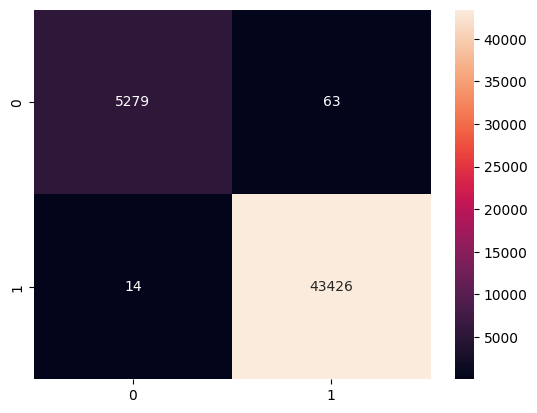

In [237]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

In [238]:
x = ['i got  vaccinated and i died'] # unrealiable tweet by me
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)
# Class 0 is fake/unrealiable tweets
# Class 1 is real/realiable tweets

In [240]:
(model.predict(x) >=0.5).astype(int)


1/1 [==============================] - 0s 16ms/step


array([[0]])

In [241]:
x = ['I got vaccinated'] # realiable tweet by me

x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)

In [242]:
(model.predict(x) >=0.5).astype(int)


1/1 [==============================] - 0s 17ms/step


array([[1]])

In [243]:
#Verified source tweet https://twitter.com/MikeASperrazza/status/1683317759503998976
x = ['The next young person who dies unexplained, and they’ve taken a COVID-19 vaccine, it’s more likely than not COVID-19 vaccine is the cause of death']

x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)

In [244]:
(model.predict(x) >=0.5).astype(int)


1/1 [==============================] - 0s 16ms/step


array([[1]])

In [245]:
# Unverified Source tweet https://twitter.com/COVID19_disease/status/1683634912350601216
x = [' BREAKING: Killer coronavirus outbreak fears as man, 28, gets struck down with MERS in Abu Dhabi - and doctors are baffled as to how he caught it']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)

In [246]:
(model.predict(x) >=0.5).astype(int)


1/1 [==============================] - 0s 16ms/step


array([[0]])